In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import gc

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
#
def autocorrelation(ys, t=1):
    return np.corrcoef(ys[:-t], ys[t:])

**Variables to help with aggregation**

In [3]:
#==========================================================================
def preprocess_sales(sales, start=1400, upper=1970):
    if start is not None:
        print("dropping...")
        to_drop = [f"d_{i+1}" for i in range(start-1)]
        print(sales.shape)
        sales.drop(to_drop, axis=1, inplace=True)
        print(sales.shape)
    #=======
    print("adding...")
    new_columns = ['d_%i'%i for i in range(1942, upper, 1)]
    for col in new_columns:
        sales[col] = np.nan
    print("melting...")
    sales = sales.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id","scale","start"],
                        var_name='d', value_name='demand')

    print("generating order")
    if start is not None:
        skip = start
    else:
        skip = 1
    sales["nb"] =sales.index // 42840 + skip
    return sales
#===============================================================
def preprocess_calendar(calendar):
    global maps, mods
    calendar["event_name"] = calendar["event_name_1"]
    calendar["event_type"] = calendar["event_type_1"]

    map1 = {mod:i for i,mod in enumerate(calendar['event_name'].unique())}
    calendar['event_name'] = calendar['event_name'].map(map1)
    map2 = {mod:i for i,mod in enumerate(calendar['event_type'].unique())}
    calendar['event_type'] = calendar['event_type'].map(map2)
    calendar['nday'] = calendar['date'].str[-2:].astype(int)
    maps["event_name"] = map1
    maps["event_type"] = map2
    mods["event_name"] = len(map1)
    mods["event_type"] = len(map2)
    calendar["wday"] -=1
    calendar["month"] -=1
    calendar["year"] -= 2011
    mods["month"] = 12
    mods["year"] = 6
    mods["wday"] = 7
    mods['snap_CA'] = 2
    mods['snap_TX'] = 2
    mods['snap_WI'] = 2

    calendar.drop(["event_name_1", "event_name_2", "event_type_1", "event_type_2", "date", "weekday"], 
                  axis=1, inplace=True)
    return calendar
#=========================================================
def make_dataset(categorize=False ,start=1400, upper= 1970):
    global maps, mods
    print("loading calendar...")
    calendar = pd.read_csv("../input/m5-forecasting-uncertainty/calendar.csv")
    print("loading sales...")
    sales = pd.read_csv("../input/walmartadd/sales.csv")
    cols = ["item_id", "dept_id", "cat_id","store_id","state_id"]
    if categorize:
        for col in cols:
            temp_dct = {mod:i for i, mod in enumerate(sales[col].unique())}
            mods[col] = len(temp_dct)
            maps[col] = temp_dct
        for col in cols:
            sales[col] = sales[col].map(maps[col])
        #

    sales =preprocess_sales(sales, start=start, upper= upper)
    calendar = preprocess_calendar(calendar)
    calendar = reduce_mem_usage(calendar)
    print("merge with calendar...")
    sales = sales.merge(calendar, on='d', how='left')
    del calendar

    print("reordering...")
    sales.sort_values(by=["id","nb"], inplace=True)
    print("re-indexing..")
    sales.reset_index(inplace=True, drop=True)
    gc.collect()

    sales['n_week'] = (sales['nb']-1)//7
    sales["nday"] -= 1
    mods['nday'] = 31
    sales = reduce_mem_usage(sales)
    gc.collect()
    return sales
#===================

In [4]:
%%time
CATEGORIZE = True;
START = 1400; UPPER = 1970;
maps = {}
mods = {}
sales = make_dataset(categorize=CATEGORIZE ,start=START, upper= UPPER)

loading calendar...
loading sales...
dropping...
(42840, 1949)
(42840, 550)
adding...
melting...
generating order
Mem. usage decreased to  0.04 Mb (78.4% reduction)
merge with calendar...
reordering...
re-indexing..
Mem. usage decreased to 1001.37 Mb (59.8% reduction)
CPU times: user 50.9 s, sys: 15.3 s, total: 1min 6s
Wall time: 1min 5s


In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24418800 entries, 0 to 24418799
Data columns (total 22 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item_id     int16  
 2   dept_id     int8   
 3   cat_id      int8   
 4   store_id    int8   
 5   state_id    int8   
 6   scale       float16
 7   start       int16  
 8   d           object 
 9   demand      float16
 10  nb          int16  
 11  wm_yr_wk    int16  
 12  wday        int8   
 13  month       int8   
 14  year        int8   
 15  snap_CA     int8   
 16  snap_TX     int8   
 17  snap_WI     int8   
 18  event_name  int8   
 19  event_type  int8   
 20  nday        int8   
 21  n_week      int16  
dtypes: float16(2), int16(5), int8(13), object(2)
memory usage: 1001.4+ MB


As we are asked to predict a time window of 28 days, the easiest way to go now is to use the last 28 days for validation:

In [6]:
sales["x"] = sales["demand"] / sales["scale"]

In [7]:
LAGS = [28, 29, 30, 31, 32, 33]
FEATS = []
for lag in tqdm(LAGS):
    sales[f"x_{lag}"] = sales.groupby("id")["x"].shift(lag)
    FEATS.append(f"x_{lag}")

100%|██████████| 6/6 [00:21<00:00,  3.56s/it]


In [8]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24418800 entries, 0 to 24418799
Data columns (total 29 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item_id     int16  
 2   dept_id     int8   
 3   cat_id      int8   
 4   store_id    int8   
 5   state_id    int8   
 6   scale       float16
 7   start       int16  
 8   d           object 
 9   demand      float16
 10  nb          int16  
 11  wm_yr_wk    int16  
 12  wday        int8   
 13  month       int8   
 14  year        int8   
 15  snap_CA     int8   
 16  snap_TX     int8   
 17  snap_WI     int8   
 18  event_name  int8   
 19  event_type  int8   
 20  nday        int8   
 21  n_week      int16  
 22  x           float16
 23  x_28        float16
 24  x_29        float16
 25  x_30        float16
 26  x_31        float16
 27  x_32        float16
 28  x_33        float16
dtypes: float16(9), int16(5), int8(13), object(2)
memory usage: 1.3+ GB


In [9]:
#sales.loc[(sales.start>1844)&(sales.nb>1840)&(sales.nb<1850), ['id','start','nb','demand']]
#sales.start.max() #1845

In [10]:
print(sales.shape)
sales = sales.loc[sales.nb>sales.start]
print(sales.shape)

(24418800, 29)
(24268220, 29)


In [11]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,scale,start,d,demand,...,event_type,nday,n_week,x,x_28,x_29,x_30,x_31,x_32,x_33
0,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1400,2296.0,...,0,27,199,4.929688,NaN,NaN,NaN,NaN,NaN,NaN
1,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1401,2984.0,...,0,28,200,6.406250,NaN,NaN,NaN,NaN,NaN,NaN
2,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1402,3228.0,...,0,29,200,6.929688,NaN,NaN,NaN,NaN,NaN,NaN
3,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1403,2868.0,...,0,0,200,6.156250,NaN,NaN,NaN,NaN,NaN,NaN
4,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1404,2312.0,...,0,1,200,4.964844,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
nb = sales['nb'].values
MAX_LAG = max(LAGS)
#tr_mask = np.logical_and(nb>START + MAX_LAG, nb<=1913)
tr_mask = np.logical_and(nb>START + MAX_LAG, nb<=1941) 
val_mask = np.logical_and(nb>1913, nb<=1941)
te_mask = np.logical_and(nb>1941, nb<=1969)

In [13]:
nb

array([1400, 1401, 1402, ..., 1967, 1968, 1969], dtype=int16)

In [14]:
scale = sales['scale'].values
ids = sales['id'].values
#y = sales['demand'].values
#ys = y / scale
ys = sales['x'].values
Z = sales[FEATS].values

In [15]:
sales['x']

0           4.929688
1           6.406250
2           6.929688
3           6.156250
4           4.964844
              ...   
24418795         NaN
24418796         NaN
24418797         NaN
24418798         NaN
24418799         NaN
Name: x, Length: 24268220, dtype: float16

In [16]:
scale

array([ 465.8,  465.8,  465.8, ..., 1440. , 1440. , 1440. ], dtype=float16)

In [17]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24268220 entries, 0 to 24418799
Data columns (total 29 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item_id     int16  
 2   dept_id     int8   
 3   cat_id      int8   
 4   store_id    int8   
 5   state_id    int8   
 6   scale       float16
 7   start       int16  
 8   d           object 
 9   demand      float16
 10  nb          int16  
 11  wm_yr_wk    int16  
 12  wday        int8   
 13  month       int8   
 14  year        int8   
 15  snap_CA     int8   
 16  snap_TX     int8   
 17  snap_WI     int8   
 18  event_name  int8   
 19  event_type  int8   
 20  nday        int8   
 21  n_week      int16  
 22  x           float16
 23  x_28        float16
 24  x_29        float16
 25  x_30        float16
 26  x_31        float16
 27  x_32        float16
 28  x_33        float16
dtypes: float16(9), int16(5), int8(13), object(2)
memory usage: 1.5+ GB


In [18]:
sv = scale[val_mask]
se = scale[te_mask]
ids = ids[te_mask]
ids = ids.reshape((-1, 28))

In [19]:
se

array([ 465.8,  465.8,  465.8, ..., 1440. , 1440. , 1440. ], dtype=float16)

In [20]:
ca = sales[['snap_CA']].values
tx = sales[['snap_TX']].values
wi = sales[['snap_WI']].values
wday = sales[['wday']].values
month = sales[['month']].values
year = sales[['year']].values
event = sales[['event_name']].values
nday = sales[['nday']].values
lag1=sales[['x_28']].values

In [21]:
item = sales[['item_id']].values
dept = sales[['dept_id']].values
cat = sales[['cat_id']].values
store = sales[['store_id']].values
state = sales[['state_id']].values

In [22]:
Z

array([[   nan,    nan,    nan,    nan,    nan,    nan],
       [   nan,    nan,    nan,    nan,    nan,    nan],
       [   nan,    nan,    nan,    nan,    nan,    nan],
       ...,
       [ 8.9  ,  7.99 ,  7.668,  7.816,  8.625, 13.18 ],
       [10.234,  8.9  ,  7.99 ,  7.668,  7.816,  8.625],
       [10.336, 10.234,  8.9  ,  7.99 ,  7.668,  7.816]], dtype=float16)

In [23]:
sales[FEATS]

,x_28,x_29,x_30,x_31,x_32,x_33
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
24418795,7.667969,7.816406,8.625000,13.179688,13.132812,9.218750
24418796,7.988281,7.667969,7.816406,8.625000,13.179688,13.132812
24418797,8.898438,7.988281,7.667969,7.816406,8.625000,13.179688
24418798,10.234375,8.898438,7.988281,7.667969,7.816406,8.625000


In [24]:
ca

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int8)

In [25]:
def make_data(mask):
    x = {"snap_CA":ca[mask], "snap_TX":tx[mask], "snap_WI":wi[mask], "wday":wday[mask], 
         "month":month[mask], "year":year[mask], "event":event[mask], "nday":nday[mask], 
         "item":item[mask], "dept":dept[mask], "cat":cat[mask], "store":store[mask], 
         "state":state[mask],"num":Z[mask]}
    t = ys[mask]
    return x, t

In [26]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24268220 entries, 0 to 24418799
Data columns (total 29 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item_id     int16  
 2   dept_id     int8   
 3   cat_id      int8   
 4   store_id    int8   
 5   state_id    int8   
 6   scale       float16
 7   start       int16  
 8   d           object 
 9   demand      float16
 10  nb          int16  
 11  wm_yr_wk    int16  
 12  wday        int8   
 13  month       int8   
 14  year        int8   
 15  snap_CA     int8   
 16  snap_TX     int8   
 17  snap_WI     int8   
 18  event_name  int8   
 19  event_type  int8   
 20  nday        int8   
 21  n_week      int16  
 22  x           float16
 23  x_28        float16
 24  x_29        float16
 25  x_30        float16
 26  x_31        float16
 27  x_32        float16
 28  x_33        float16
dtypes: float16(9), int16(5), int8(13), object(2)
memory usage: 1.5+ GB


In [27]:
xt, yt = make_data(tr_mask) #train
xv, yv = make_data(val_mask) # val
xe, ye = make_data(te_mask) # test

In [28]:
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [29]:
qs = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]

In [30]:
q = tf.constant(np.array([qs]), dtype=tf.float32)
q

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[0.005, 0.025, 0.165, 0.25 , 0.5  , 0.75 , 0.835, 0.975, 0.995]],
      dtype=float32)>

In [31]:
ca = L.Input((1,), name="snap_CA")
ca

<tf.Tensor 'snap_CA:0' shape=(None, 1) dtype=float32>

In [32]:
#=====
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)
#============================#
def make_model(n_in):
    
    num = L.Input((n_in,), name="num")
    
    ca = L.Input((1,), name="snap_CA")
    tx = L.Input((1,), name="snap_TX")
    wi = L.Input((1,), name="snap_WI")
    wday = L.Input((1,), name="wday")
    month = L.Input((1,), name="month")
    year = L.Input((1,), name="year")
    event = L.Input((1,), name="event")
    nday = L.Input((1,), name="nday")
    item = L.Input((1,), name="item")
    dept = L.Input((1,), name="dept")
    cat = L.Input((1,), name="cat")
    store = L.Input((1,), name="store")
    state = L.Input((1,), name="state")
    inp = {"snap_CA":ca, "snap_TX":tx, "snap_WI":wi, "wday":wday, 
           "month":month, "year":year, "event":event, "nday":nday,
           "item":item, "dept":dept, "cat":cat, "store":store, 
           "state":state, "num":num} 
    #
    ca_ = L.Embedding(mods["snap_CA"], mods["snap_CA"], name="ca_3d")(ca)
    tx_ = L.Embedding(mods["snap_TX"], mods["snap_TX"], name="tx_3d")(tx)
    wi_ = L.Embedding(mods["snap_WI"], mods["snap_WI"], name="wi_3d")(wi)
    wday_ = L.Embedding(mods["wday"], mods["wday"], name="wday_3d")(wday)
    month_ = L.Embedding(mods["month"], mods["month"], name="month_3d")(month)
    year_ = L.Embedding(mods["year"], mods["year"], name="year_3d")(year)
    event_ = L.Embedding(mods["event_name"], mods["event_name"], name="event_3d")(event)
    nday_ = L.Embedding(mods["nday"], mods["nday"], name="nday_3d")(nday)
    item_ = L.Embedding(mods["item_id"], 10, name="item_3d")(item)
    dept_ = L.Embedding(mods["dept_id"], mods["dept_id"], name="dept_3d")(dept)
    cat_ = L.Embedding(mods["cat_id"], mods["cat_id"], name="cat_3d")(cat)
    store_ = L.Embedding(mods["store_id"], mods["store_id"], name="store_3d")(store)
    state_ = L.Embedding(mods["state_id"], mods["state_id"], name="state_3d")(state)
    
    p = [ca_, tx_, wi_, wday_, month_, year_, event_, nday_, item_, dept_, cat_, store_, state_]
    emb = L.Concatenate(name="embds")(p)
    context = L.Flatten(name="context")(emb)
    
    x = L.Concatenate(name="x1")([context, num])
    x = L.Dense(500, activation="relu", name="d1")(x)
    x = L.Dropout(0.3)(x)
    x = L.Concatenate(name="m1")([x, context])
    x = L.Dense(500, activation="relu", name="d2")(x)
    x = L.Dropout(0.3)(x)
    x = L.Concatenate(name="m2")([x, context])
    x = L.Dense(500, activation="relu", name="d3")(x)
    preds = L.Dense(9, activation="linear", name="preds")(x)
    model = M.Model(inp, preds, name="M1")
    model.compile(loss=qloss, optimizer="adam")
    return model


In [33]:
net = make_model(len(FEATS))
ckpt = ModelCheckpoint("w.h5", monitor='val_loss', verbose=1, save_best_only=True,mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
es = EarlyStopping(monitor='val_loss', patience=3)
print(net.summary())

Model: "M1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
snap_CA (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
snap_TX (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
snap_WI (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
wday (InputLayer)               [(None, 1)]          0                                            
_________________________________________________________________________________________________

In [34]:
net.fit(xt, yt, batch_size=50_000, epochs=20, validation_data=(xv, yv), callbacks=[ckpt, reduce_lr, es])

Train on 21654373 samples, validate on 1199520 samples
Epoch 1/20
21650000/21654373 [============================>.] - ETA: 0s - loss: 0.2087
Epoch 00001: val_loss improved from inf to 0.22838, saving model to w.h5
21654373/21654373 [==============================] - 1175s 54us/sample - loss: 0.2087 - val_loss: 0.2284
Epoch 2/20
21650000/21654373 [============================>.] - ETA: 0s - loss: 0.1988
Epoch 00002: val_loss improved from 0.22838 to 0.22406, saving model to w.h5
21654373/21654373 [==============================] - 1185s 55us/sample - loss: 0.1988 - val_loss: 0.2241
Epoch 3/20
21650000/21654373 [============================>.] - ETA: 0s - loss: 0.1966
Epoch 00003: val_loss improved from 0.22406 to 0.22160, saving model to w.h5
21654373/21654373 [==============================] - 1163s 54us/sample - loss: 0.1966 - val_loss: 0.2216
Epoch 4/20
21650000/21654373 [============================>.] - ETA: 0s - loss: 0.1944
Epoch 00004: val_loss improved from 0.22160 to 0.21894,

In [35]:
nett = make_model(len(FEATS))
nett.load_weights("w.h5")

In [36]:
pv = nett.predict(xv, batch_size=50_000, verbose=1)
pe = nett.predict(xe, batch_size=50_000, verbose=1)

1199520/1199520 [==============================] - 34s 28us/sample


In [37]:
pv

array([[ 5.1589613,  5.4906626,  5.791505 , ...,  6.3554   ,  6.8886285,
         7.2480855],
       [ 4.9816675,  5.1255035,  5.2455773, ...,  5.7243586,  6.254382 ,
         6.723924 ],
       [ 4.495223 ,  4.656832 ,  4.840279 , ...,  5.3986616,  5.8927145,
         6.3683457],
       ...,
       [ 7.270783 ,  7.8636203,  8.338037 , ...,  9.229961 ,  9.775403 ,
        10.245756 ],
       [ 8.52697  ,  9.259734 ,  9.928467 , ..., 11.016327 , 11.740277 ,
        12.309168 ],
       [ 8.274552 ,  8.982259 ,  9.724009 , ..., 10.781851 , 11.379125 ,
        12.078576 ]], dtype=float32)

In [38]:
nett.evaluate(xv, yv, batch_size=50_000)

1199520/1199520 [==============================] - 19s 16us/sample - loss: 0.2118


0.21175560287209977

In [39]:
pv = pv.reshape((-1, 28, 9))
pe = pe.reshape((-1, 28, 9))

In [40]:
sv = sv.reshape((-1, 28))
se = se.reshape((-1, 28))

In [41]:
Yv = yv.reshape((-1, 28))

FOODS_3_598_WI_2


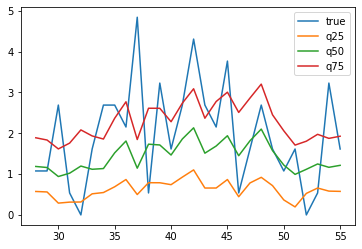

In [42]:
k = np.random.randint(0, 42840)
#k = np.random.randint(0, 200)
print(ids[k, 0])
plt.plot(np.arange(28, 56), Yv[k], label="true")
plt.plot(np.arange(28, 56), pv[k ,:, 3], label="q25")
plt.plot(np.arange(28, 56), pv[k ,:, 4], label="q50")
plt.plot(np.arange(28, 56), pv[k, :, 5], label="q75")
plt.legend(loc="best")
plt.show()

In [43]:
#Prediction

In [44]:
names = [f"F{i+1}" for i in range(28)]

In [45]:
names

['F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'F9',
 'F10',
 'F11',
 'F12',
 'F13',
 'F14',
 'F15',
 'F16',
 'F17',
 'F18',
 'F19',
 'F20',
 'F21',
 'F22',
 'F23',
 'F24',
 'F25',
 'F26',
 'F27',
 'F28']

In [46]:
piv = pd.DataFrame(ids[:, 0], columns=["id"])

In [47]:
piv.head(50)

,id
0,CA_1_FOODS
1,CA_1_FOODS_1
2,CA_1_FOODS_2
3,CA_1_FOODS_3
4,CA_1_HOBBIES
5,CA_1_HOBBIES_1
6,CA_1_HOBBIES_2
7,CA_1_HOUSEHOLD
8,CA_1_HOUSEHOLD_1
9,CA_1_HOUSEHOLD_2


In [48]:
sv

array([[4.658e+02, 4.658e+02, 4.658e+02, ..., 4.658e+02, 4.658e+02,
        4.658e+02],
       [5.641e+01, 5.641e+01, 5.641e+01, ..., 5.641e+01, 5.641e+01,
        5.641e+01],
       [8.494e+01, 8.494e+01, 8.494e+01, ..., 8.494e+01, 8.494e+01,
        8.494e+01],
       ...,
       [5.010e-01, 5.010e-01, 5.010e-01, ..., 5.010e-01, 5.010e-01,
        5.010e-01],
       [3.921e-01, 3.921e-01, 3.921e-01, ..., 3.921e-01, 3.921e-01,
        3.921e-01],
       [1.440e+03, 1.440e+03, 1.440e+03, ..., 1.440e+03, 1.440e+03,
        1.440e+03]], dtype=float16)

In [49]:
QUANTILES = ["0.005", "0.025", "0.165", "0.250", "0.500", "0.750", "0.835", "0.975", "0.995"]
VALID = []
EVAL = []

for i, quantile in tqdm(enumerate(QUANTILES)):
    t1 = pd.DataFrame(pv[:,:, i]*sv, columns=names)
    t1 = piv.join(t1)
    t1["id"] = t1["id"] + f"_{quantile}_validation"
    t2 = pd.DataFrame(pe[:,:, i]*se, columns=names)
    t2 = piv.join(t2)
    t2["id"] = t2["id"] + f"_{quantile}_evaluation"
    VALID.append(t1)
    EVAL.append(t2)
#============#

9it [00:00, 17.27it/s]


In [50]:
sv

array([[4.658e+02, 4.658e+02, 4.658e+02, ..., 4.658e+02, 4.658e+02,
        4.658e+02],
       [5.641e+01, 5.641e+01, 5.641e+01, ..., 5.641e+01, 5.641e+01,
        5.641e+01],
       [8.494e+01, 8.494e+01, 8.494e+01, ..., 8.494e+01, 8.494e+01,
        8.494e+01],
       ...,
       [5.010e-01, 5.010e-01, 5.010e-01, ..., 5.010e-01, 5.010e-01,
        5.010e-01],
       [3.921e-01, 3.921e-01, 3.921e-01, ..., 3.921e-01, 3.921e-01,
        3.921e-01],
       [1.440e+03, 1.440e+03, 1.440e+03, ..., 1.440e+03, 1.440e+03,
        1.440e+03]], dtype=float16)

In [51]:
sub = pd.DataFrame()
sub = sub.append(VALID + EVAL)
del VALID, EVAL, t1, t2

In [52]:
sub_round = sub.round()

In [53]:
sub_round.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,CA_1_FOODS_0.005_validation,2403.0,2320.0,2094.0,2121.0,2413.0,3084.0,3137.0,2518.0,2417.0,...,2455.0,3143.0,3440.0,2462.0,2286.0,2331.0,2308.0,2531.0,3195.0,3428.0
1,CA_1_FOODS_1_0.005_validation,194.0,179.0,170.0,185.0,202.0,237.0,235.0,188.0,200.0,...,233.0,263.0,232.0,202.0,206.0,204.0,215.0,250.0,298.0,275.0
2,CA_1_FOODS_2_0.005_validation,326.0,309.0,272.0,267.0,315.0,442.0,470.0,408.0,396.0,...,318.0,432.0,510.0,371.0,328.0,314.0,287.0,317.0,417.0,496.0
3,CA_1_FOODS_3_0.005_validation,1532.0,1456.0,1305.0,1300.0,1488.0,2030.0,2089.0,1596.0,1514.0,...,1580.0,2086.0,2321.0,1611.0,1537.0,1519.0,1443.0,1630.0,2135.0,2381.0
4,CA_1_HOBBIES_0.005_validation,341.0,330.0,313.0,311.0,344.0,440.0,429.0,336.0,347.0,...,338.0,449.0,447.0,333.0,332.0,326.0,322.0,365.0,445.0,447.0


In [54]:
sub_round.to_csv("submission.csv", index=False)